In [17]:
#Liberia para gestionar fechas
library(lubridate)
#libreria para manejar bases de datos
library(dplyr)
#libreria para ajustar distribuciones
library(MASS)

In [2]:
estacion=read.csv('D:/Proyectos_GitHub/curso_hidrologia/data/Estaciones/estacion9.csv')

In [3]:
head(estacion)

fecha,pp
1/1/1964,0.0
1/2/1964,0.0
1/3/1964,0.0
1/4/1964,0.7
1/5/1964,1.2
1/6/1964,2.1


El operador %>% sirve para concatenar varias funciones y ahorrarnos lineas de comandos.
Queremos calcular el maximo diario ocurrido en cada año de registro

Primero vamos a darle formato a la columna de fechas a uno que R pueda manipular, seguido de la cracion de dos nuevas columnas (año y mes), y finalmente vamos a calular el valor maximo anual 

In [4]:
max_anual=estacion%>%
  mutate(fecha = as.Date(fecha, format="%m/%d/%Y"))%>% 
  mutate(mes = month(fecha),ano=year(fecha))%>%
  group_by(ano) %>%
  summarise(precip= max(pp,na.rm=T))

In [5]:
head(max_anual)

ano,precip
1964,23.0
1965,31.4
1966,38.0
1967,42.1
1968,24.6
1969,25.1


Ajuste de la distribucion normal en los datos

In [6]:
my_data=max_anual$precip
fit <- fitdistr(my_data,densfun = 'normal')
fit

      mean          sd    
  33.0250000    7.5702575 
 ( 1.0498058) ( 0.7423248)

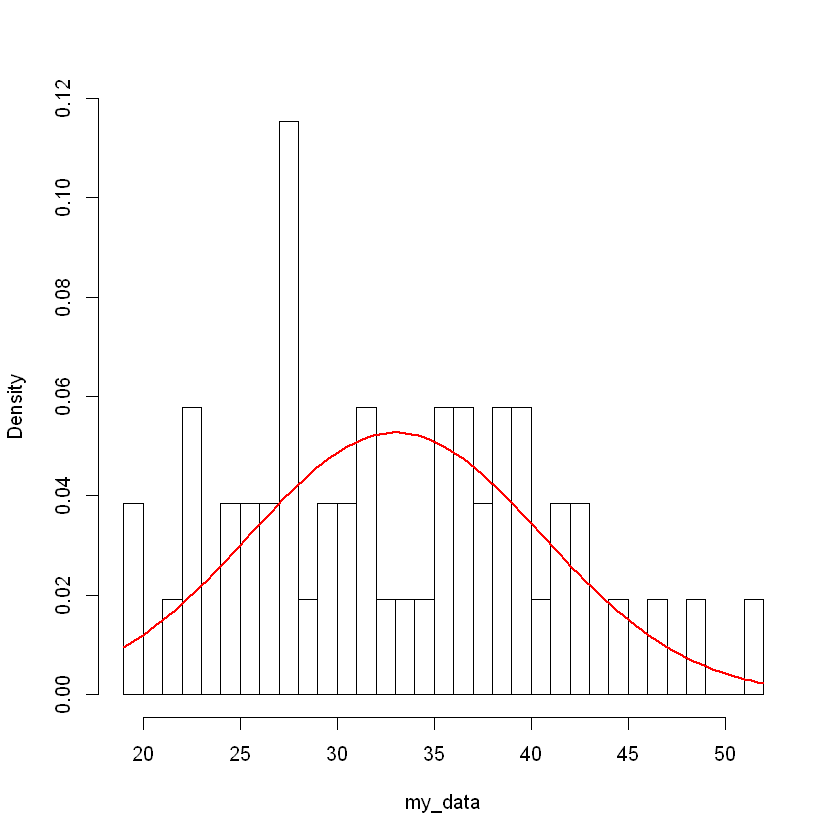

In [7]:
hist(my_data, pch=20, breaks=25, prob=TRUE, main="")
curve(dnorm(x, fit$estimate[1], fit$estimate[2]), col="red", lwd=2, add=T)

# Usando la liberia fitdistrplus 

In [18]:
library(fitdistrplus)

Probando las distribuciones weibull, gamma, lognormal y gumbel. Debido a que la distribución gumbel no está programada en el paquete fitdistrplus tenemos que explícitamente agregar una función de densidad, probabilidad y cuantiles.

función de densidad Gumbel

$$\Large  f(x,a,b)=\frac{e^{\frac{(a-x)}{b}}}{b} e^{-e^{\frac{a-x}{b}}}$$

In [9]:
dgumbel <- function(x, a, b) 1/b*exp((a-x)/b)*exp(-exp((a-x)/b))
pgumbel <- function(q, a, b) exp(-exp((a-q)/b))
qgumbel <- function(p, a, b) a-b*log(-log(p))

Procedemos a realizar la calibración. Para el caso de gumbel se sugiere un punto inicial de busqueda

In [10]:
fit_w  <- fitdist(my_data, "weibull")
fit_g  <- fitdist(my_data, "gamma")
fit_ln <- fitdist(my_data, "lnorm")
fit_gum <- fitdist(my_data, "gumbel",start=list(a=30, b=10))
#summary(fit_ln)

$start.arg
$start.arg$shape
[1] 5.087535

$start.arg$scale
[1] 35.97698


$fix.arg
NULL

$start.arg
$start.arg$shape
[1] 19.03112

$start.arg$rate
[1] 0.576264


$fix.arg
NULL

$start.arg
$start.arg$meanlog
[1] 3.470448

$start.arg$sdlog
[1] 0.2335916


$fix.arg
NULL

$start.arg
$start.arg$a
[1] 30

$start.arg$b
[1] 10


$fix.arg
NULL



Graficando los resultados

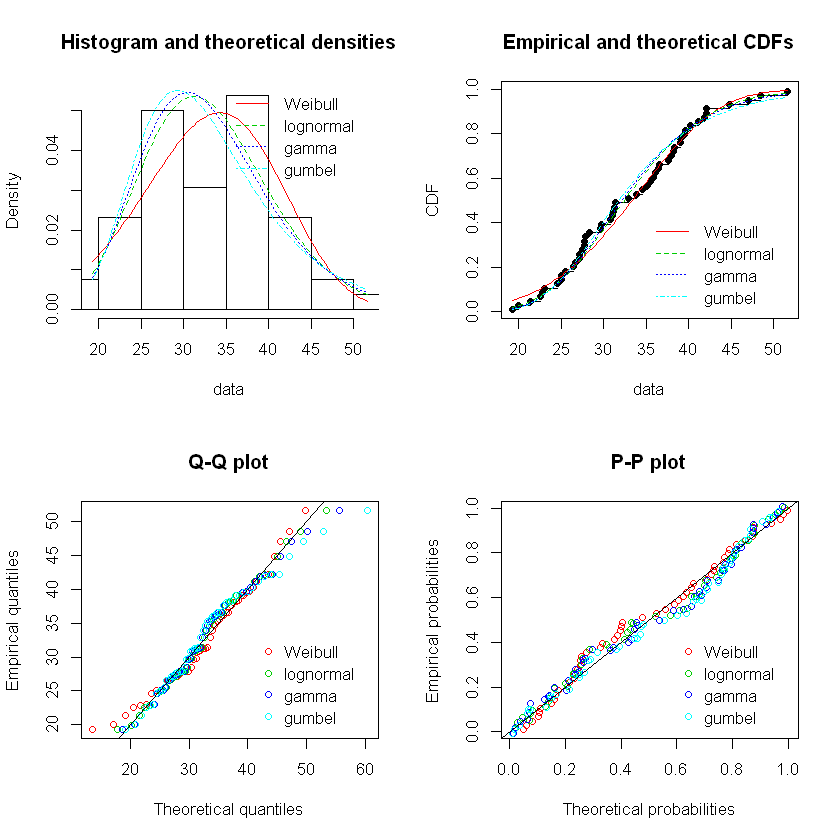

In [11]:
par(mfrow=c(2,2))
plot.legend <- c("Weibull", "lognormal", "gamma",'gumbel')
denscomp(list(fit_w, fit_g, fit_ln,fit_gum), legendtext = plot.legend)
cdfcomp (list(fit_w, fit_g, fit_ln,fit_gum), legendtext = plot.legend)
qqcomp  (list(fit_w, fit_g, fit_ln,fit_gum), legendtext = plot.legend)
ppcomp  (list(fit_w, fit_g, fit_ln,fit_gum), legendtext = plot.legend)

El paquete también proporciona algunas estadísticas interesantes:

In [12]:
gofstat(list(fit_w, fit_g, fit_ln,fit_gum), fitnames = c("Weibull","gamma", "lognormal",'gumbel'))

Goodness-of-fit statistics
                                Weibull      gamma  lognormal     gumbel
Kolmogorov-Smirnov statistic 0.09453402 0.08296080 0.09324416 0.10220194
Cramer-von Mises statistic   0.06175074 0.06636964 0.07316471 0.07985872
Anderson-Darling statistic   0.41448822 0.34705130 0.39052484 0.46288936

Goodness-of-fit criteria
                                Weibull    gamma lognormal   gumbel
Akaike's Information Criterion 363.5471 360.8297  361.2613 362.8522
Bayesian Information Criterion 367.4496 364.7321  365.1638 366.7547

# Periodos de retorno usando gumbel

Probabilidad de excedencia

$$\Large P(x \geq X)= \frac{1}{Tr}$$

Donde Tr es el tiempo de retorno

<b> Distribución acumulada de gumbel</b>

$$\Large F(x) = e^{-e^{(a-x)/b}} $$

despejando x se obtiene:
    
$$\Large x = a-bLn(-Ln(F(x))) $$

Implementando en una función el valor de x

In [13]:
x_de_retorno<- function(Fx, a, b){
 #Fx es la probabilidad acumulada para cierto periodo de retorno
 # a y b parametros de la distribucion gumbel
    a-b*log(-log(Fx))
}

Para un Tr de 50 años se tiene que P(x>=X) = 1/50. Este valor corresponde a el área bajo la curva de la distribución hacia la cola derecha. Para encontrar el valor del área de la cola izquierda tenemos que sustraer a 1 el valor de 1/50.

Expresado en ecuación:

$$\Large F(x) = 1-P(x \geq X) $$

In [16]:
a=fit_gum$estimate[['a']]
b=fit_gum$estimate[['b']]

Trs=c(5,10,50,100,200) # periodos de retorno en años
Px = 1/Trs # probabilidades de excedencia
Fx= 1-Px   

tabla = data.frame(Trs,Px,Fx)
tabla['x']=lapply(tabla['Fx'],x_de_retorno,a,b)

In [15]:
tabla

Trs,Px,Fx,x
5,0.200,0.800,39.35291
10,0.100,0.900,44.36256
50,0.020,0.980,55.38801
100,0.010,0.990,60.04908
200,0.005,0.995,64.69314
